
# Solution

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
file_path = './data/rating_stats.csv'
df = pd.read_csv(file_path, delimiter=';')

df.head()

,id,player_name,player_id,fixture_id,league_round,rating,event_datetime,team_name,position,home_or_away,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,1,A. Barák,8779,390,1,0.0,17/08/2024 18:30,Fiorentina,Midfielder,away,...,0,0,0,0,0,0,0,0,0,0.0
1,2,A. Barák,8779,392,2,7.3,25/08/2024 18:30,Fiorentina,Midfielder,home,...,0,0,0,0,0,0,0,0,0,5.5
2,3,A. Bastoni,8619,384,1,6.9,17/08/2024 18:30,Inter,Defender,away,...,1,1,0,0,0,0,0,0,0,6.5
3,4,A. Bastoni,8619,394,2,7.2,24/08/2024 20:45,Inter,Defender,home,...,0,1,0,0,0,0,0,0,0,6.5
4,5,A. Bastoni,8619,404,3,7.5,30/08/2024 20:45,Inter,Defender,home,...,1,1,0,0,0,0,0,0,0,6.5


In [3]:
print(df.columns)

Index(['id', 'player_name', 'player_id', 'fixture_id', 'league_round',
       'rating', 'event_datetime', 'team_name', 'position', 'home_or_away',
       'opponent_team', 'result', 'result_status', 'games_minutes',
       'games_substitute', 'offsides', 'shots_total', 'shots_on',
       'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
       'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
       'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'rating_target'],
      dtype='object')


## Data Preparation

In [4]:
# Filtro colonne
columns_to_keep = [
    'rating', 'position', 'result_status', 'games_minutes',
    'games_substitute', 'offsides', 'shots_total', 'shots_on',
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
    'penalty_committed', 'penalty_scored', 'penalty_missed',
    'penalty_saved', 'rating_target'
]

df_filtered = df[columns_to_keep]

df_filtered.head()

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,0.0,Midfielder,D,0,VERO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5


In [5]:
# Filtro righe con games_minutes > 0
# in quanto non rilevanti perché il target sarà 0
# inoltre potrebbe aggiungere rumore al modello

df_filtered = df_filtered[df_filtered['games_minutes'] > 0]
df_filtered

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,...,3,5,0,0,0,0,0,0,0,6.0
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,...,1,3,0,0,0,0,0,0,0,6.0
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,...,0,1,0,0,0,0,0,0,0,5.5
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,...,2,4,0,0,0,0,0,0,0,5.5


### Encoding delle variabili categoriche

In [6]:
# One-Hot Encoding per position
df_encoded = pd.get_dummies(df_filtered, columns=['position'], drop_first=True)
df_encoded


,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,...,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder
1,7.3,D,55,FALSO,0,2,2,0,0,0,...,0,0,0,0,0,0,5.5,False,False,True
2,6.9,D,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,0,6.5,True,False,False
3,7.2,W,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,0,6.5,True,False,False
4,7.5,W,61,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,0,6.5,True,False,False
6,7.0,L,82,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,0,6.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,D,71,FALSO,2,1,0,0,0,0,...,0,0,0,0,0,0,6.0,False,False,False
2244,6.9,D,67,FALSO,1,1,0,0,0,0,...,0,0,0,0,0,0,6.0,False,False,False
2245,6.6,L,90,FALSO,0,2,1,0,0,0,...,0,0,0,0,0,0,5.5,False,False,False
2246,6.9,L,90,FALSO,0,1,0,0,0,0,...,0,0,0,0,0,0,5.5,False,False,False


In [7]:
# Ordinal Encoding per result_status
# perché ha un ordine intrinseco
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[['L', 'D', 'W']])
df_encoded['result_status_encoded'] = ordinal_encoder.fit_transform(df_encoded[['result_status']])
df_encoded

,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,...,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded
1,7.3,D,55,FALSO,0,2,2,0,0,0,...,0,0,0,0,0,5.5,False,False,True,1.0
2,6.9,D,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,6.5,True,False,False,1.0
3,7.2,W,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,6.5,True,False,False,2.0
4,7.5,W,61,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,6.5,True,False,False,2.0
6,7.0,L,82,FALSO,0,0,0,0,0,0,...,0,0,0,0,0,6.0,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,D,71,FALSO,2,1,0,0,0,0,...,0,0,0,0,0,6.0,False,False,False,1.0
2244,6.9,D,67,FALSO,1,1,0,0,0,0,...,0,0,0,0,0,6.0,False,False,False,1.0
2245,6.6,L,90,FALSO,0,2,1,0,0,0,...,0,0,0,0,0,5.5,False,False,False,0.0
2246,6.9,L,90,FALSO,0,1,0,0,0,0,...,0,0,0,0,0,5.5,False,False,False,0.0


In [8]:
# Label Encoding per games_substitute
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded['games_substitute_encoded'] = le.fit_transform(df_encoded['games_substitute'])
df_encoded

,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,...,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,7.3,D,55,FALSO,0,2,2,0,0,0,...,0,0,0,0,5.5,False,False,True,1.0,0
2,6.9,D,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,6.5,True,False,False,1.0,0
3,7.2,W,90,FALSO,0,0,0,0,0,0,...,0,0,0,0,6.5,True,False,False,2.0,0
4,7.5,W,61,FALSO,0,0,0,0,0,0,...,0,0,0,0,6.5,True,False,False,2.0,0
6,7.0,L,82,FALSO,0,0,0,0,0,0,...,0,0,0,0,6.0,True,False,False,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,D,71,FALSO,2,1,0,0,0,0,...,0,0,0,0,6.0,False,False,False,1.0,0
2244,6.9,D,67,FALSO,1,1,0,0,0,0,...,0,0,0,0,6.0,False,False,False,1.0,0
2245,6.6,L,90,FALSO,0,2,1,0,0,0,...,0,0,0,0,5.5,False,False,False,0.0,0
2246,6.9,L,90,FALSO,0,1,0,0,0,0,...,0,0,0,0,5.5,False,False,False,0.0,0


In [9]:
# rimuovo le colonne che non servono più
df_encoded = df_encoded.drop('result_status', axis=1)
df_encoded = df_encoded.drop('games_substitute', axis=1)

In [10]:
df = df_encoded.copy()
df.head()

,rating,games_minutes,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,...,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,7.3,55,0,2,2,0,0,0,0,19,...,0,0,0,0,5.5,False,False,True,1.0,0
2,6.9,90,0,0,0,0,0,0,0,72,...,0,0,0,0,6.5,True,False,False,1.0,0
3,7.2,90,0,0,0,0,0,0,0,87,...,0,0,0,0,6.5,True,False,False,2.0,0
4,7.5,61,0,0,0,0,0,0,0,47,...,0,0,0,0,6.5,True,False,False,2.0,0
6,7.0,82,0,0,0,0,0,0,0,60,...,0,0,0,0,6.0,True,False,False,0.0,0


### Conversione True / False

In [11]:
df['position_Defender'] = df['position_Defender'].astype(int)
df['position_Goalkeeper'] = df['position_Goalkeeper'].astype(int)
df['position_Midfielder'] = df['position_Midfielder'].astype(int)
df['result_status_encoded'] = df['result_status_encoded'].astype(int)
df.head()

,rating,games_minutes,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,...,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,7.3,55,0,2,2,0,0,0,0,19,...,0,0,0,0,5.5,0,0,1,1,0
2,6.9,90,0,0,0,0,0,0,0,72,...,0,0,0,0,6.5,1,0,0,1,0
3,7.2,90,0,0,0,0,0,0,0,87,...,0,0,0,0,6.5,1,0,0,2,0
4,7.5,61,0,0,0,0,0,0,0,47,...,0,0,0,0,6.5,1,0,0,2,0
6,7.0,82,0,0,0,0,0,0,0,60,...,0,0,0,0,6.0,1,0,0,0,0


### Robust Scaler
Normalizzazione dei dati. Uso Robust Scaler perché meno influenzato dagli outlier, inoltre, mantiene la distribuzione originale dei dati

In [12]:
from sklearn.preprocessing import RobustScaler

numerical_columns = [
    'rating', 'games_minutes', 'offsides', 'shots_total', 'shots_on', 
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves', 
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total', 
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn', 
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won', 
    'penalty_committed', 'penalty_scored', 'penalty_missed', 'penalty_saved'
    #'rating_target'
]

data_scaler = RobustScaler()
df[numerical_columns] = data_scaler.fit_transform(df[numerical_columns])

target_scaler = RobustScaler()
df['rating_target'] = target_scaler.fit_transform(df[['rating_target']])


df.head()

,rating,games_minutes,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,...,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,0.666667,-0.379310,0.0,2.0,2.0,0.0,0.0,0.0,0.0,-0.142857,...,0.0,0.0,0.0,0.0,-0.5,0,0,1,1,0
2,0.000000,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.750000,...,0.0,0.0,0.0,0.0,0.5,1,0,0,1,0
3,0.500000,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.285714,...,0.0,0.0,0.0,0.0,0.5,1,0,0,2,0
4,1.000000,-0.275862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857143,...,0.0,0.0,0.0,0.0,0.5,1,0,0,2,0
6,0.166667,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.321429,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


In [13]:
# Salvataggio dello scaler per uso successivo nella fase di post-processing

#caler_filename = './scalers/robust_scaler.pkl'
#import joblib
#joblib.dump(scaler, scaler_filename)

## Suddivisione in train/test e allenamento del modello LightGBM


In [14]:
X = df.drop('rating_target', axis=1)
y = df['rating_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definizione del modello LightGBM con i parametri ottimizzati
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.01,
    max_depth=20,
    n_estimators=500,
    num_leaves=50
)

# Allenamento del modello
lgb_model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = lgb_model.predict(X_test)

#  performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}, R²: {r2:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 28
[LightGBM] [Info] Start training from score -0.425081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

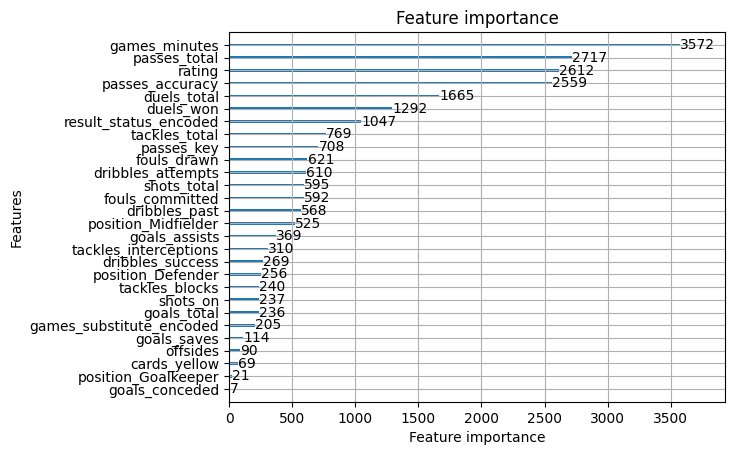

In [15]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=50)
plt.show()

In [16]:
# Inverso dello scaling per 'rating_target' su y_test e y_pred
y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Arrotondamento al mezzo punto più vicino per i valori predetti
y_pred_rounded = np.round(y_pred_original * 2) / 2

# Valutazione delle performance del modello
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_rounded))
r2 = r2_score(y_test_original, y_pred_rounded)

print(f'RMSE (rating originale): {rmse:.4f}')
print(f'R² (rating originale): {r2:.4f}')

RMSE (rating originale): 1.0641
R² (rating originale): 0.6665


In [17]:
print("y_test_original | y_pred_original")
print("------------------------------")
for y_test, y_pred in zip(y_test_original, y_pred_original):
    print(f"{y_test:<15} | {y_pred:<15}")

y_test_original | y_pred_original
------------------------------
6.5             | 6.102656921784753
6.5             | 6.4044624763658495
5.5             | 5.6710080712436275
0.0             | 3.1995604692265105
6.5             | 6.496864202471198
7.0             | 6.727264977017346
5.0             | 5.293294261929699
6.5             | 5.272604466321895
0.0             | -0.439545345323336
5.5             | 5.524631949739906
5.5             | 6.0043034133553075
5.5             | 5.233655506930378
7.0             | 6.877606672490588
0.0             | 4.6298549590968845
7.0             | 6.757047658990457
6.0             | 5.397935543863719
5.5             | 5.672683312247046
6.0             | 5.671831917850072
6.0             | 5.819944101522077
5.5             | 6.295081609382866
5.5             | 5.670686100950099
7.5             | 7.001673539050842
0.0             | 1.8217754720146822
6.0             | 2.901047217016137
6.0             | 5.968795285988632
0.0             | 5.83678681

In [18]:
# Recupera il dataset filtrato basato sugli indici di X_test (il dataset `df_filtered`)
X_test_filtered = df_filtered.loc[X_test.index, :].copy()

# Aggiungi le colonne del 'rating_target' originale e predetto al dataset filtrato
X_test_filtered['rating_target_original'] = y_test_original  # Valori originali del target
X_test_filtered['rating_target_predicted'] = y_pred_rounded  # Valori predetti (arrotondati)

# Stampa del dataset ricostruito
print(X_test_filtered.head())

# Se vuoi salvare il dataset ricostruito su file CSV per ulteriori analisi
X_test_filtered.to_csv('./out/rating_predictions.csv', index=False)

      rating    position result_status  games_minutes games_substitute  \
1726     6.9    Defender             W             90            FALSO   
118      7.2    Defender             D             86            FALSO   
494      6.3  Midfielder             L             64            FALSO   
1548     7.0    Attacker             W             11             VERO   
2011     7.0    Defender             W             62            FALSO   

      offsides  shots_total  shots_on  goals_total  goals_conceded  ...  \
1726         0            0         0            0               0  ...   
118          0            0         0            0               0  ...   
494          0            0         0            0               0  ...   
1548         0            0         0            0               0  ...   
2011         0            0         0            0               0  ...   

      cards_yellow  cards_red  penalty_won  penalty_committed  penalty_scored  \
1726             0     

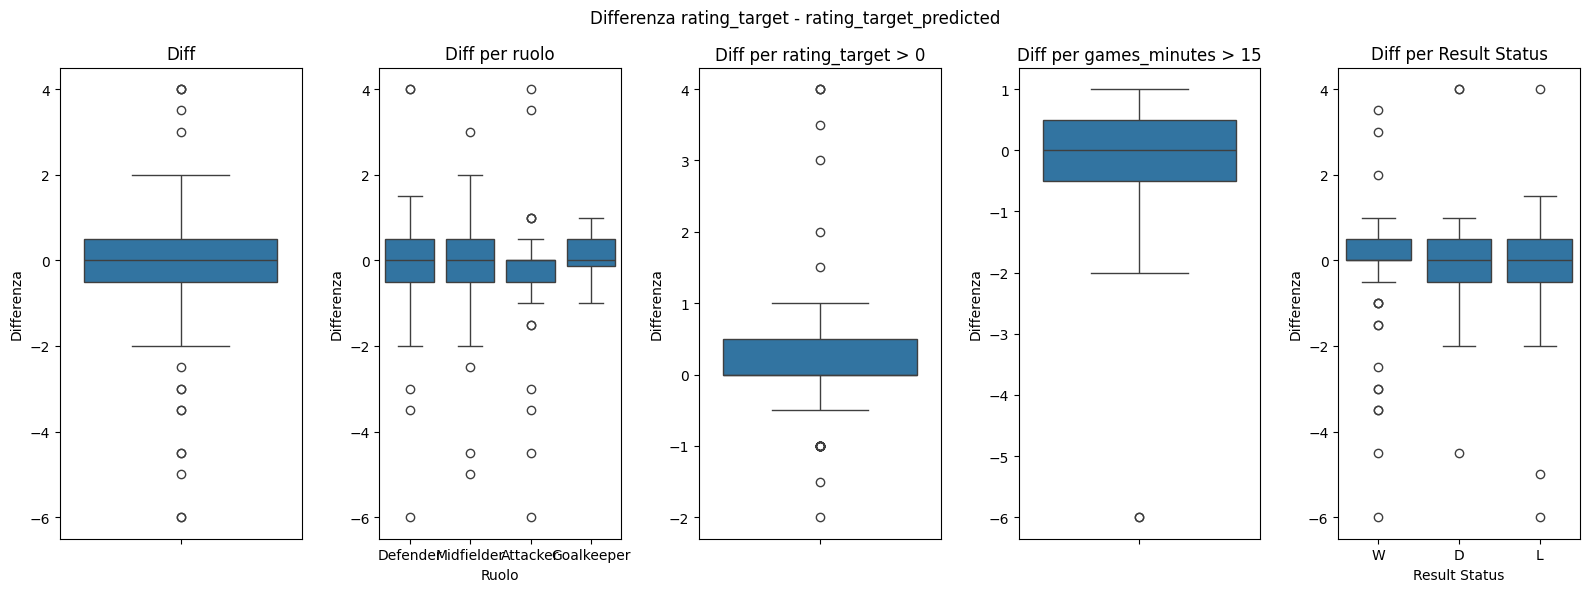

In [19]:
df = X_test_filtered.copy()

# differenza tra rating target e rating_target_predicted
df['rating_diff'] = df['rating_target'] - df['rating_target_predicted']

# Stats di base sulla differenza tra rating e rating target
diff_overall = df['rating_diff'].describe()

# Statistiche di base sulla differenza, raggruppata per ruolo (position)
diff_by_position = df.groupby('position')['rating_diff'].describe()

# Filtrare righe con rating_target > 0
filtered_df = df[(df['rating_target'] > 0)]
diff_filtered = filtered_df['rating_diff'].describe()

# Impostazioni per i grafici
plt.figure(figsize=(16, 6))
plt.suptitle("Differenza rating_target - rating_target_predicted")

# Boxplot della differenza complessiva tra rating_target e rating
plt.subplot(1, 5, 1)
sns.boxplot(y=df['rating_diff'])
plt.title('Diff')
plt.ylabel('Differenza')

# Boxplot della differenza per ruolo (position)
plt.subplot(1, 5, 2)
sns.boxplot(x=df['position'], y=df['rating_diff'])
plt.title('Diff per ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Differenza')

# Boxplot delle righe filtrate con rating_target > 0
filtered_df = df[df['rating_target'] > 0]
plt.subplot(1, 5, 3)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per rating_target > 0')
plt.ylabel('Differenza')

# Boxplot delle righe filtrate con games_minutes > 15
filtered_df = df[df['games_minutes'] > 15]
plt.subplot(1, 5, 4)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per games_minutes > 15')
plt.ylabel('Differenza')

# 4. Boxplot della differenza rispetto a result_status
plt.subplot(1, 5, 5)
sns.boxplot(x=df['result_status'], y=df['rating_diff'])
plt.title('Diff per Result Status')
plt.xlabel('Result Status')
plt.ylabel('Differenza')

plt.tight_layout()
plt.show()

In [20]:
pd.set_option('display.max_columns', None)
df[(abs(df['rating_diff']) > 1.5)].head(20)

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,rating_target_original,rating_target_predicted,rating_diff
1548,7.0,Attacker,W,11,VERO,0,0,0,0,0,0,0,4,0,4,1,0,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,3.0,-3.0
2183,6.7,Midfielder,W,14,VERO,0,0,0,0,0,0,0,8,0,7,0,0,0.0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,4.5,-4.5
206,6.0,Defender,D,11,VERO,0,0,0,0,0,0,0,1,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2.0,-2.0
584,7.2,Midfielder,W,11,VERO,0,1,1,0,0,0,0,14,0,14,2,0,0.0,6,4,2,2,1,0,0,0,0,0,0,0,0,0,6.0,6.0,3.0,3.0
111,6.3,Attacker,L,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.0,-6.0
912,6.6,Defender,W,11,VERO,0,0,0,0,0,0,0,7,0,7,0,0,1.0,2,1,1,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,3.0,-3.0
470,6.3,Defender,D,12,VERO,0,0,0,0,0,0,0,3,0,1,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,6.0,2.0,4.0
705,7.3,Midfielder,L,14,VERO,0,0,0,0,0,0,0,5,0,5,0,0,0.0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0.0,5.0,-5.0
1648,6.3,Attacker,W,12,VERO,0,2,1,0,0,0,0,4,0,2,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,5.5,5.5,2.0,3.5
2092,6.3,Defender,W,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.0,-6.0


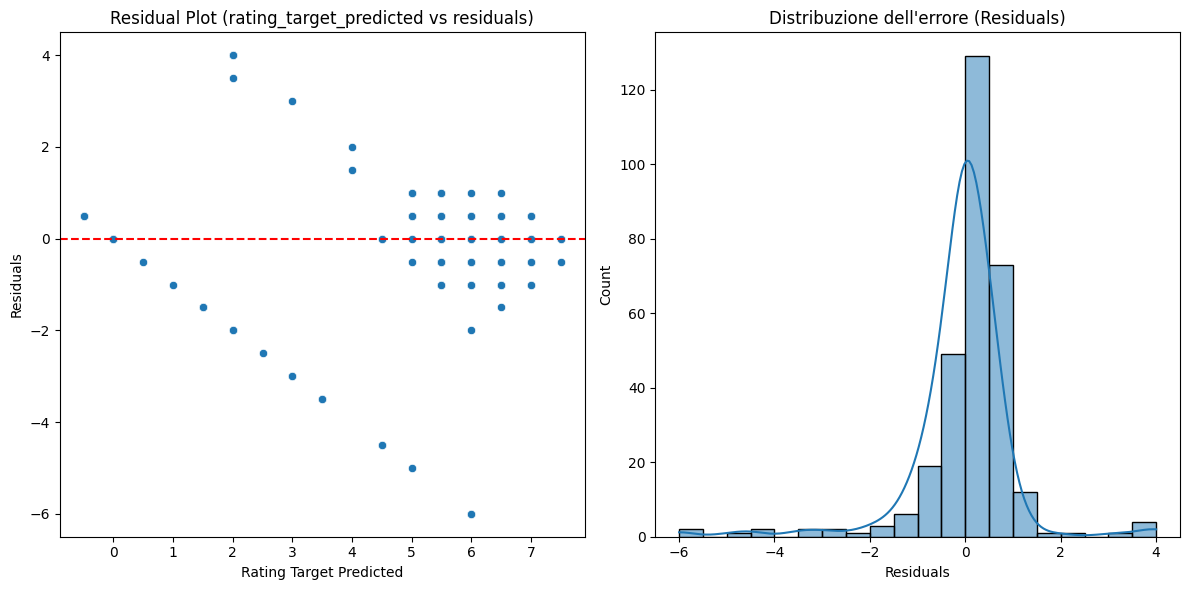

In [26]:
# 1. Residual Plot (Grafico dei residui)
plt.figure(figsize=(12, 6))

# Calcolare i residui (errore)
df['residuals'] = df['rating_target'] - df['rating_target_predicted']

# Residual plot: rating_target vs residui
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['rating_target_predicted'], y=df['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (rating_target_predicted vs residuals)')
plt.xlabel('Rating Target Predicted')
plt.ylabel('Residuals')

# Distribuzione dell'errore
plt.subplot(1, 2, 2)
sns.histplot(df['residuals'], kde=True, bins=20)
plt.title('Distribuzione dell\'errore (Residuals)')
plt.xlabel('Residuals')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [175]:
# Errore medio assoluto (MAE)
mae = np.mean(np.abs(df['residuals']))
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calcola l'RMSE
rmse = root_mean_squared_error(df['rating_target'], df['rating_target_predicted'])

print("RMSE:", rmse)

Mean Absolute Error (MAE): 0.55
RMSE: 1.064098301288558


## Conclusioni

Dai risultati ottenuti, è evidente che c'è stato un piccolo miglioramento del rating.
Però ci sono ancora dei problemi da risolvere, quali:
- gli outlier
- alcune caratteristiche importanti, non sono abbastanza rilevanti, esempio goals_total, goals_assists, penalty_scored, penalty_saved, penalty_missed, penalty_committed, penalty_won, cards_red